## ⭐ Autogluon은 **코랩**에서 진행함. GPU와 RAM이 필요하기 때문!

### 📌 AutoGluon이란?
**AutoGluon**은 Amazon에서 개발한 **AutoML(Auto Machine Learning) 라이브러리**로,

딥러닝 및 머신러닝 모델을 **자동으로 최적화**하고 **탐색**할 수 있도록 도와줌!

특히, **딥러닝 지식 없이도 손쉽게 강력한 모델을 만들 수 있는 것이 장점**

---

#### 🚀 AutoGluon의 주요 기능
##### ✅ 1. AutoML 모델 학습 및 최적화
- `AutoGluon.TabularPredictor`를 활용하여 자동으로 최적의 모델 조합(Stacking, Ensemble)을 찾음!

##### ✅ 2. 하이퍼파라미터 자동 튜닝
- `hyperparameter_tune_kwargs`를 사용하여 하이퍼파라미터를 자동으로 탐색하고 최적화

##### ✅ 3. 다양한 모델 지원
- XGBoost, LightGBM, CatBoost, Neural Networks 등 다양한 알고리즘을 자동으로 학습

##### ✅ 4. 데이터 전처리 자동화
- 결측치 처리, 범주형 변수 변환 등을 자동 수행하여 데이터 전처리 부담 감소

---

### ✅ Autogluon 코랩 코드

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [ ]:
import time
from IPython.display import display, Javascript

def prevent_disconnect():
    display(Javascript('''
        function ClickConnect(){
            console.log("코랩 연결 유지");
            document.querySelector("colab-toolbar-button#connect").click();
        }
        setInterval(ClickConnect, 60000);
    '''))

prevent_disconnect()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [ ]:
plt.rc('font', family='NanumBarunGothic', size=11)
plt.rcParams['axes.unicode_minus'] = True
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

In [ ]:
# 01_11_LGHV_FeatureEngineering.ipynb 까지 끝낸 데이터를 삽입

datapath_df = '/content/drive/MyDrive/Colab Notebooks/data/full_data/TPS_cancel_preprocessing3.csv'
df = pd.read_csv(datapath_df)

#### 1️. AutoGluon 설치

In [ ]:
!pip install autogluon

#### 2. 2,3,4,5,6,7월 train / 9월 test
Autogluon은 validation 작업을 스스로 혼자함.

In [ ]:
train = df[df['p_mt'].isin([2,3,4,5,6,7])]
test = df[df['p_mt'] == 9]

In [ ]:
train['p_mt'].describe()

In [ ]:
display(train, test)

#### 3. train 데이터 불균형 처리 - 랜덤 언더 샘플링 진행
- 언더 샘플링을 5:5로 맞추지않고, 실무에서도 해지를 하는 고객 비율이 더 적기 때문에 6(N):4(Y)의 비율로 맞추고 진행해보겠음.

In [ ]:
train['churn'].value_counts(normalize=True) * 100

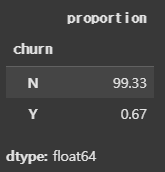

In [ ]:
from sklearn.utils import resample

# 데이터 분리
df_Y = train[train['churn'] == 'Y']
df_N = train[train['churn'] == 'N']

# Y의 데이터 개수와 비율에 따른 N의 샘플 개수 계산
y_count = len(df_Y)  # Y 데이터 개수
n_count_target = int((6 / 4) * y_count)  # 7:3 비율로 N 데이터 개수 계산

# N 데이터를 랜덤 샘플링
df_N_downsampled = resample(
    df_N,
    replace=False,  # 복원 샘플링 하지 않음
    n_samples=n_count_target,  # 목표 샘플 개수
    random_state=42  # 재현성을 위한 시드
)

# 언더샘플링된 데이터 결합
train_balanced = pd.concat([df_Y, df_N_downsampled])

# 결과 섞기 (선택 사항)
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print("최종 데이터 분포:")
print(train_balanced['churn'].value_counts())

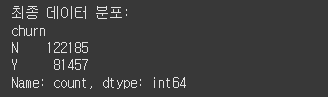

In [ ]:
train = train_balanced

#### 4. 컬럼 drop 및 레이블 인코딩 진행

In [ ]:
drop_cols = ['sha2_hash','p_mt','AGMT_END_YMD']

train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [ ]:
display(train.shape)
display(test.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 데이터 병합
combined = pd.concat([train, test], keys=['train', 'test'])

# 레이블 인코딩
label_encoders = {}
for column in combined.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    combined[column] = le.fit_transform(combined[column])
    label_encoders[column] = le

# 데이터 분리
train = combined.xs('train')
test = combined.xs('test')

In [ ]:
display(train, test)

### ⭐ 5. AutoGluon 진행

In [ ]:
from autogluon.tabular import TabularPredictor

# 타겟 컬럼 지정
target_column = 'churn'

# AutoGluon 모델 학습
predictor = TabularPredictor(
    label=target_column,       # 예측할 타겟 컬럼
    eval_metric='roc_auc'      # 불균형 데이터에 적합한 평가 지표
).fit(
    train_data=train,          # 학습 데이터
    presets='best_quality',    # 고품질 설정
    time_limit=14400           # 학습 시간 제한 (4시간)
)

# 리더보드 확인
print("Leaderboard:")
print(predictor.leaderboard(extra_info=True))

# 테스트 데이터 평가
test_performance = predictor.evaluate(test)
print("Test Performance:", test_performance)

# 특성 중요도 확인
feature_importance = predictor.feature_importance(train)
print("Feature Importance:")
print(feature_importance.head(10))

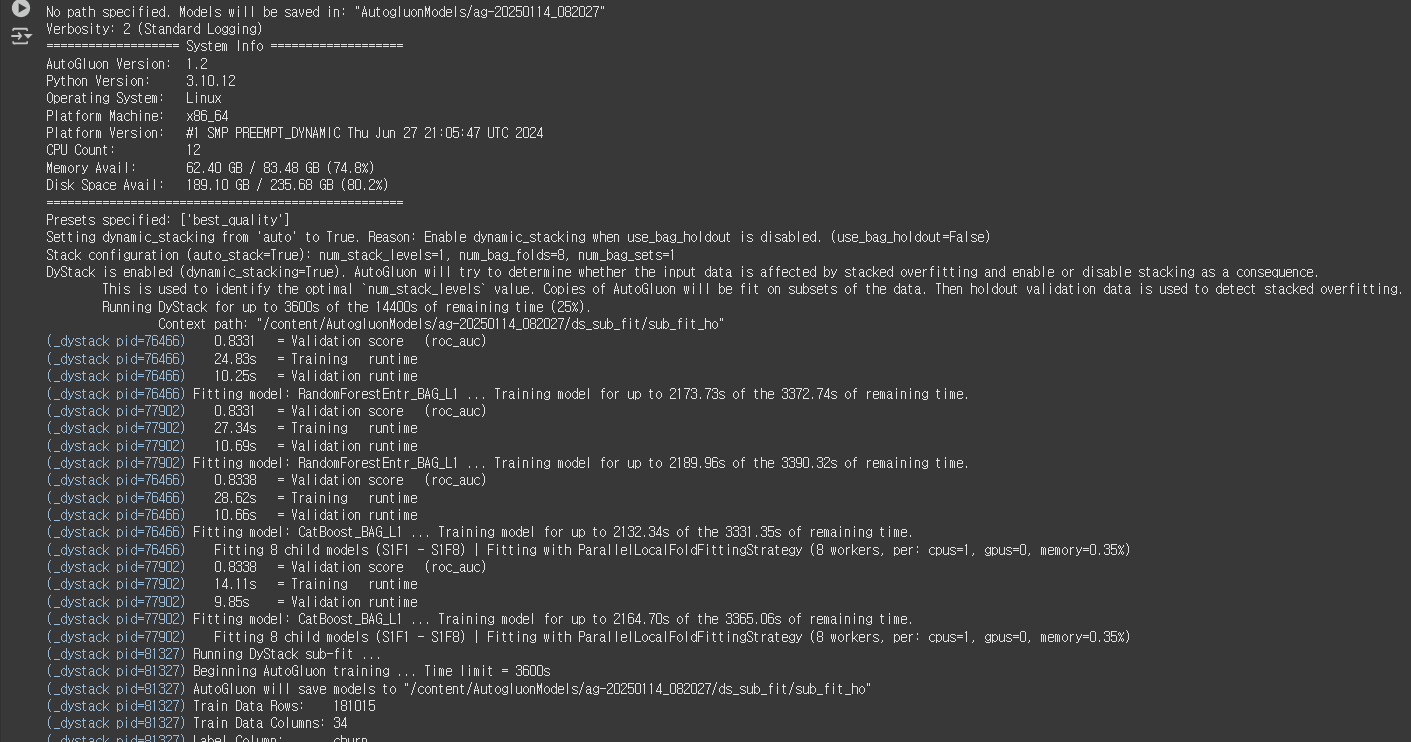

#### 🚀 AutoGluon Leaderboard

| Rank | Model                            | Score (ROC AUC) | Prediction Time (s) |
|------|----------------------------------|----------------|---------------------|
| 1    | WeightedEnsemble_L3         | 0.84       | 527.79              |
| 2    | NeuralNetTorch_r79_BAG_L2       | 0.84           | 451.30              |
| 3    | NeuralNetFastAI_BAG_L2          | 0.84           | 453.06              |
| 4    | LightGBM_r131_BAG_L2            | 0.84           | 475.36              |
| 5    | CatBoost_BAG_L2                 | 0.84           | 450.18              |
| 6    | CatBoost_r177_BAG_L2            | 0.84           | 450.19              |
| 7    | LightGBM_BAG_L2                 | 0.84           | 452.10              |
| 8    | CatBoost_r9_BAG_L2              | 0.84           | 450.65              |
| 9    | CatBoost_r137_BAG_L2            | 0.84           | 450.19              |
| 10   | LightGBMLarge_BAG_L2            | 0.84           | 454.79              |
| 11   | XGBoost_BAG_L2                  | 0.84           | 451.60              |
| 12   | LightGBMXT_BAG_L2               | 0.84           | 453.65              |
| 13   | XGBoost_r33_BAG_L2              | 0.84           | 463.92              |
| 14   | LightGBM_r96_BAG_L2             | 0.84           | 485.38              |
| 15   | NeuralNetTorch_r22_BAG_L2       | 0.84           | 452.06              |
| 16   | NeuralNetTorch_BAG_L2           | 0.84           | 451.29              |
| 17   | NeuralNetFastAI_r191_BAG_L2     | 0.84           | 455.02              |
| 18   | WeightedEnsemble_L2         | 0.84       | 154.64              |
| 19   | NeuralNetFastAI_r102_BAG_L2     | 0.84           | 451.23              |
| 20   | ExtraTreesGini_BAG_L2           | 0.84           | 462.97              |
| 21   | ExtraTreesEntr_BAG_L2           | 0.84           | 463.37              |
| 22   | LightGBM_r131_BAG_L1            | 0.84           | 51.13               |
| 23   | XGBoost_r33_BAG_L1              | 0.84           | 29.45               |
| 24   | LightGBM_r130_BAG_L1            | 0.84           | 5.94                |
| 25   | CatBoost_r13_BAG_L1             | 0.84           | 0.27                |
| 26   | CatBoost_r9_BAG_L1              | 0.84           | 0.78                |
| 27   | LightGBMLarge_BAG_L1            | 0.84           | 8.75                |
| 28   | RandomForestEntr_BAG_L2         | 0.84           | 464.94              |
| 29   | ExtraTrees_r42_BAG_L2           | 0.84           | 464.60              |
| 30   | CatBoost_BAG_L1             | 0.84       | 0.15            |
| 31   | CatBoost_r177_BAG_L1            | 0.84           | 0.13                |
| 32   | RandomForestGini_BAG_L2         | 0.84           | 464.50              |
| 33   | LightGBM_BAG_L1                 | 0.84           | 8.91                |
| 34   | XGBoost_r89_BAG_L1              | 0.84           | 4.36                |
| 35   | CatBoost_r137_BAG_L1            | 0.84           | 0.23                |
| 36   | XGBoost_BAG_L1                  | 0.84           | 2.89                |
| 37   | CatBoost_r50_BAG_L1             | 0.84           | 0.75                |
| 38   | RandomForestEntr_BAG_L1         | 0.83           | 10.70               |
| 39   | RandomForestGini_BAG_L1         | 0.83           | 10.34               |
| 40   | LightGBM_r96_BAG_L1             | 0.83           | 126.55              |
| 41   | LightGBMXT_BAG_L1               | 0.83           | 15.37               |

#### 🚀 Feature Importance

| Feature                 | Importance | Std Dev | p-value | n  | p99_high | p99_low |
|-------------------------|------------|---------|---------|----|----------|---------|
| MONTHS_REMAINING       | 0.17       | 0.00    | 0.00    | 5  | 0.18     | 0.16    |
| TOTAL_USED_DAYS        | 0.14       | 0.00    | 0.00    | 5  | 0.15     | 0.14    |
| CH_HH_AVG_MONTH1       | 0.06       | 0.00    | 0.00    | 5  | 0.07     | 0.06    |
| INHOME_RATE            | 0.05       | 0.00    | 0.00    | 5  | 0.05     | 0.05    |
| SCRB_PATH_NM_GRP       | 0.05       | 0.00    | 0.00    | 5  | 0.05     | 0.05    |
| CH_LAST_DAYS_BF_GRP    | 0.05       | 0.00    | 0.00    | 5  | 0.05     | 0.05    |
| CH_25_RATIO_1MONTH     | 0.04       | 0.00    | 0.00    | 5  | 0.04     | 0.04    |
| CH_FAV_RNK1           | 0.04       | 0.00    | 0.00    | 5  | 0.04     | 0.04    |
| AGE_GRP10             | 0.04       | 0.00    | 0.00    | 5  | 0.04     | 0.04    |
| AGMT_KIND_NM          | 0.03       | 0.00    | 0.00    | 5  | 0.04     | 0.03    |


#### 6. 모델 저장

In [ ]:
import os
from google.colab import drive

# 저장 경로 설정
save_path = '/content/drive/MyDrive/Colab Notebooks/ag-final-model'

# 모델 저장
print("Saving model to Google Drive...")
predictor.save(save_path)  # 학습된 모델 저장
print(f"Model saved to: {save_path}")

# Saving model to Google Drive...
# Model saved to: /content/drive/MyDrive/Colab Notebooks/ag-final-model

#### 7. 모델 성능 평가

In [ ]:
from autogluon.tabular import TabularPredictor

# 모델 경로 설정
model_path = '/content/drive/MyDrive/Colab Notebooks/AutogluonModels/ag-20250114_082027/'

# 모델 불러오기
predictor = TabularPredictor.load(model_path)
print("Model loaded successfully!")

# 모델 정보를 확인하려면
print(predictor.leaderboard())

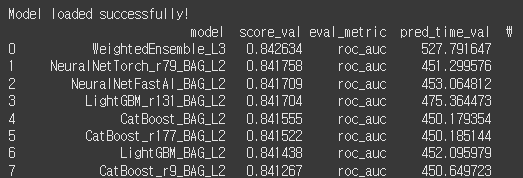

In [ ]:
# Best 모델 이름 확인

best_model_name = predictor.model_best
print(f"Best Model: {best_model_name}")


# Best Model: WeightedEnsemble_L3

In [ ]:
# WeightedEnsemble_L3의 구성 모델들 확인
ensemble_info = predictor.info()
ensemble_details = ensemble_info['model_info'][best_model_name]
print(f"{best_model_name} Details:", ensemble_details)

# WeightedEnsemble_L3 Details: {'name': 'WeightedEnsemble_L3', 'model_type': 'WeightedEnsembleModel', 'problem_type': 'binary', 'eval_metric': 'roc_auc', 'stopping_metric': 'roc_auc', 'fit_time': 49.40677762031555, 'num_classes': 2,......

In [ ]:
# 데이터 불러오기

datapath_df = '/content/drive/MyDrive/Colab Notebooks/data/full_data/TPS_cancel_preprocessing3.csv'
df = pd.read_csv(datapath_df)

In [ ]:
test_data = df[df['p_mt'] == 9]

In [ ]:
drop_cols = ['sha2_hash','p_mt','AGMT_END_YMD']

test_data = test_data.drop(drop_cols, axis=1)

In [ ]:
# 시간이 너무 오래 걸려서 30만개만 추출해서 검사해보자
print(test_data.shape)
print(test_data['churn'].value_counts())

# N과 Y로 데이터 분리
n_data = test_data[test_data['churn'] == 'N']
y_data = test_data[test_data['churn'] == 'Y']

# N 데이터를 30만 개로 샘플링
n_sampled = n_data.sample(n=300000, random_state=42)

# N과 Y 데이터를 합치기
balanced_test_data = pd.concat([n_sampled, y_data])

# 데이터 섞기 (셔플링)
balanced_test_data = balanced_test_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced test_data class distribution:")
print(balanced_test_data['churn'].value_counts())

test_data = balanced_test_data


# (313229, 36)
# churn
# N    300000
# Y     13229
# Name: count, dtype: int64
# Balanced test_data class distribution:
# churn
# N    300000
# Y     13229
# Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoders = {}

# 범주형 컬럼 자동 탐지 및 레이블 인코딩 수행
for column in test_data.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    test_data[column] = le.fit_transform(test_data[column])
    label_encoders[column] = le  # 각 컬럼의 레이블 인코더 저장

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Best Model 이름 가져오기
# -----------------------------------------------------------
best_model_name = predictor.model_best
print(f"Using Best Model: {best_model_name}")

# -----------------------------------------------------------
# 테스트 데이터 평가 (Best Model)
# -----------------------------------------------------------

# 테스트 데이터 예측
test_predictions = predictor.predict(test_data, model=best_model_name)

# 테스트 데이터의 실제 값 (타겟 컬럼)
y_test = test_data['churn']  # 타겟 컬럼 이름을 사용
X_test = test_data.drop(columns=['churn'])  # 입력 피처

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy (Best Model): {test_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Best Model):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Best Model):")
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])  # 0: N, 1: Y
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix (Best Model)")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화 (Best Model)
# -----------------------------------------------------------

# 클래스 1에 대한 예측 확률 (churn = Y의 확률)
test_probabilities = predictor.predict_proba(test_data, model=best_model_name)[1]  # 클래스 1 확률만 추출

# AUC-ROC 계산
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC (Best Model): {test_auc:.2f}")

# ROC Curve 계산
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve (Best Model)")
plt.legend()
plt.show()

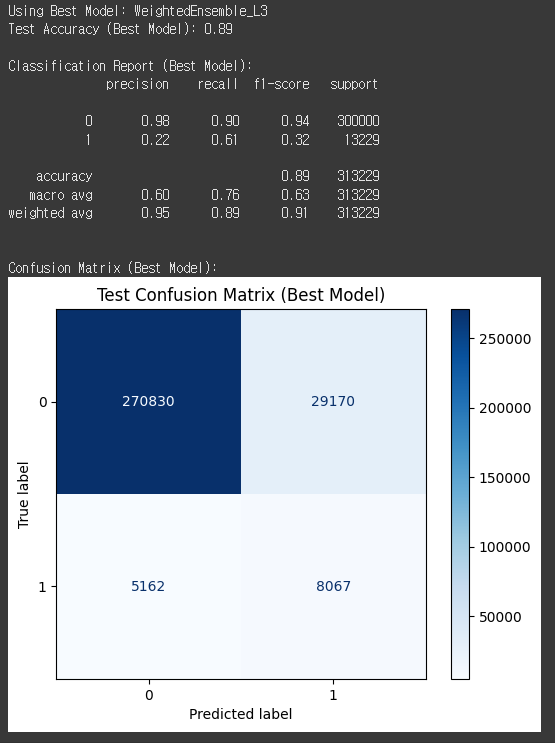

Autogluon에서 모델이 나왔지만, accuracy는 상당히 높지만 실제 1인데 모델이 0이라고 생각하는 경우의 수가 너무 많기 때문에 LightGBM모델을 쓰는 편이 좋을듯하다.